# Assignment 1 (new working doc)

## Links
- https://cbscanvas.instructure.com/courses/41482/files/1504373?wrap=1
- https://insideairbnb.com/get-the-data/

## Approach
1. data cleaning & standardization
### EDA
2. correlation analysis
3. graphing
### Clustering
4. choose clustering algorithm
5. run clustering algorithm
6. graph clusters
### PCA
7. run pca

In [107]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [108]:
# data
with open('./data/listings.csv', 'r') as file:
    df_listings = pd.read_csv(file)
    
df_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,371299,Marais Rue des Archives refait à neuf février ...,1870265,Thomas,NaN,Hôtel-de-Ville,48.85751,2.35511,Entire home/apt,185.0,3,601,2024-09-06,3.97,3,307,54,7510300547558
1,371862,loft in Paris (Belleville),1872631,Veronique,NaN,Entrepôt,48.87151,2.37219,Entire home/apt,250.0,4,50,2023-08-14,0.34,1,9,0,7511000320406
2,372879,Appartement complet au centre de Paris.,1876396,Samuel,NaN,Gobelins,48.83593,2.35108,Entire home/apt,85.0,30,171,2024-08-15,2.01,3,151,1,"Available with a mobility lease only (""bail mo..."
3,375434,"Luxurious Art & Design Flat, 180m2, Champs Ely...",683140,Oscar,NaN,Élysée,48.86680,2.30972,Entire home/apt,NaN,3,22,2023-07-15,0.15,1,0,0,7510806561916
4,378897,Little flat near Montmartre,1902818,Lorraine,NaN,Opéra,48.88285,2.33462,Entire home/apt,110.0,3,28,2024-07-30,0.19,1,6,2,7511805895013


## 1. data cleaning & standardization
- after this step we will have two dataframes one with only numeric columns and the other with only both
- we standardize the data with z-score normalization

In [109]:
## drop na prices
df_listings_clean = df_listings.dropna(subset=['price'])

## drop irrelevant columns
drop_cols_listing = ['id', 'host_id', 'neighbourhood_group', 'license', 'last_review']
df_listings_clean = df_listings_clean.drop(columns=drop_cols_listing)


# we make the assumption that if revievews_per_month is nan, it means that there are no reviews and we can replace it with 0
df_listings_clean['reviews_per_month'] = df_listings_clean['reviews_per_month'].fillna(0)

## non numeric columns
def drop_non_numeric(df):
    return df.select_dtypes(include=['number'])

df_listings_num = drop_non_numeric(df_listings_clean)

df_listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64230 entries, 0 to 95460
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            64230 non-null  object 
 1   host_name                       64230 non-null  object 
 2   neighbourhood                   64230 non-null  object 
 3   latitude                        64230 non-null  float64
 4   longitude                       64230 non-null  float64
 5   room_type                       64230 non-null  object 
 6   price                           64230 non-null  float64
 7   minimum_nights                  64230 non-null  int64  
 8   number_of_reviews               64230 non-null  int64  
 9   reviews_per_month               64230 non-null  float64
 10  calculated_host_listings_count  64230 non-null  int64  
 11  availability_365                64230 non-null  int64  
 12  number_of_reviews_ltm           64230

In [110]:
df_listings_clean.isna().sum()

name                              0
host_name                         0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [111]:
# standardize the data
def z_score_normalize(col):
    col_mean = np.mean(col)
    col_variance = np.std(col)
    return((col-col_mean)/col_variance)

df_listings_norm = pd.DataFrame()
for col in df_listings_num.columns:
    if col == 'price':
        df_listings_norm[col] = df_listings_num[col]
    else:
        df_listings_norm[col] = z_score_normalize(df_listings_num[col])
    
df_listings_norm.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,-0.346187,0.399319,185.0,-0.188825,9.415228,2.219580,-0.260815,1.026043,3.504188
1,0.431265,0.893292,250.0,-0.164072,0.404461,-0.464311,-0.279409,-1.449960,-0.549648
2,-1.544573,0.282767,85.0,0.479500,2.383232,0.770427,-0.260815,-0.270119,-0.474577
4,1.061000,-0.193275,110.0,-0.188825,0.044684,-0.575216,-0.279409,-1.474886,-0.399506
5,0.325198,0.340320,300.0,0.058703,-0.315092,-0.686120,-0.279409,1.491333,-0.324435


## 2. Correlation analysis

In [112]:
def calc_mean(col):
    """Calculate mean of a list."""
    return round(sum(col) / len(col), 6)

def calc_variance(col, mean):
    """Calculate variance of a list."""
    squared_dist = sum([(mean - x) ** 2 for x in col])
    return squared_dist / len(col)

def calc_std_dev(variance):
    """Calculate standard deviation from variance."""
    return variance ** 0.5

def calc_covariance(x_list, y_list, x_mean, y_mean):
    """Calculate covariance between two lists."""
    sum_cross_variations = sum([(x - x_mean) * (y_list[i] - y_mean) for i, x in enumerate(x_list)])
    return sum_cross_variations / len(x_list)

def calc_correlation(cov_xy, std_x, std_y):
    """Calculate correlation from covariance and standard deviations."""
    return cov_xy / (std_x * std_y)

def analyze_column_statistics(df):
    """Analyze and print statistics for each column in the dataframe."""
    for col in df.columns:
        col_list = df.loc[:, col].dropna().tolist()
        mean_col = calc_mean(col_list)
        var_col = calc_variance(col_list, mean_col)
        sd_col = calc_std_dev(var_col)
        
        print(f"Mean of {col} is {mean_col}")
        print(f"Variance of {col} is {var_col}")
        print(f"Standard Deviation of {col} is {sd_col}")

#TODO Fix built in functions
def calculate_correlation_matrix(df):
    """Calculate and print correlation matrix for the dataframe."""
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    
    for col1 in df.columns:
        for col2 in df.columns:
            x_list = df[col1].tolist()
            y_list = df[col2].tolist()
            x_mean = calc_mean(x_list)
            y_mean = calc_mean(y_list)
            cov_xy = calc_covariance(x_list, y_list, x_mean, y_mean)
            std_x = calc_std_dev(calc_variance(x_list, x_mean))
            std_y = calc_std_dev(calc_variance(y_list, y_mean))
            corr_xy = calc_correlation(cov_xy, std_x, std_y)
            corr_matrix.loc[col1, col2] = corr_xy
            
    
    return corr_matrix

# Analyze column statistics
analyze_column_statistics(df_listings_num)

# Calculate correlation matrix
corr_matrix = calculate_correlation_matrix(df_listings_num)
corr_matrix

Mean of latitude is 48.863744
Variance of latitude is 0.00032427193946897137
Standard Deviation of latitude is 0.01800755228977474
Mean of longitude is 2.341303
Variance of longitude is 0.0011955562091951308
Standard Deviation of longitude is 0.03457681606503309
Mean of price is 256.023276
Variance of price is 272763.9950210616
Standard Deviation of price is 522.2681256031825
Mean of minimum_nights is 10.628429
Variance of minimum_nights is 1632.1196339482249
Standard Deviation of minimum_nights is 40.3995004170624
Mean of number_of_reviews is 25.267601
Variance of number_of_reviews is 3739.2085704076717
Standard Deviation of number_of_reviews is 61.14906843450415
Mean of reviews_per_month is 0.967987
Variance of reviews_per_month is 1.829294057757977
Standard Deviation of reviews_per_month is 1.3525139769177903
Mean of calculated_host_listings_count is 31.053884
Variance of calculated_host_listings_count is 11569.664183494051
Standard Deviation of calculated_host_listings_count is 107

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
latitude,1.0,0.09317,-0.010187,-0.011002,-0.009288,-0.014265,-0.007201,0.00483,-0.006082
longitude,0.09317,1.0,-0.102158,-0.035261,0.031346,0.018334,-0.10097,-0.055888,0.028202
price,-0.010187,-0.102158,1.0,-0.026808,-0.047445,-0.084553,0.002825,0.057699,-0.071054
minimum_nights,-0.011002,-0.035261,-0.026808,1.0,-0.044169,-0.120161,0.086458,0.145258,-0.103297
number_of_reviews,-0.009288,0.031346,-0.047445,-0.044169,1.0,0.558154,-0.064078,0.018007,0.685175
reviews_per_month,-0.014265,0.018334,-0.084553,-0.120161,0.558154,1.0,-0.07524,-0.06183,0.800618
calculated_host_listings_count,-0.007201,-0.10097,0.002825,0.086458,-0.064078,-0.07524,1.0,0.047854,-0.066334
availability_365,0.00483,-0.055888,0.057699,0.145258,0.018007,-0.06183,0.047854,1.0,-0.020699
number_of_reviews_ltm,-0.006082,0.028202,-0.071054,-0.103297,0.685175,0.800618,-0.066334,-0.020699,1.0


In [113]:
#sns.pairplot(df_listings_num)

# from the pairplot deem longitude, latitude and availability365 to be the most interesting features to cluster with respect to the price

In [114]:
corr_matrix.info()
# sns.heatmap(corr_matrix, annot=True)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, latitude to number_of_reviews_ltm
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   latitude                        9 non-null      object
 1   longitude                       9 non-null      object
 2   price                           9 non-null      object
 3   minimum_nights                  9 non-null      object
 4   number_of_reviews               9 non-null      object
 5   reviews_per_month               9 non-null      object
 6   calculated_host_listings_count  9 non-null      object
 7   availability_365                9 non-null      object
 8   number_of_reviews_ltm           9 non-null      object
dtypes: object(9)
memory usage: 1020.0+ bytes


4. Choosing a Clustering Algorithm
As seen in the pairplot, there are no clearly separeted clusters in the data. therefore we try to cluster the data through the density based clustering algorithm DBSCAN

In [115]:
def use_dbscan(X, eps, min_samples):
    """Use DBSCAN to cluster data and return labels."""
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    print(dbscan.labels_)
    return dbscan.labels_

In [116]:


df_listings_num.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,48.85751,2.35511,185.0,3,601,3.97,3,307,54
1,48.87151,2.37219,250.0,4,50,0.34,1,9,0
2,48.83593,2.35108,85.0,30,171,2.01,3,151,1
4,48.88285,2.33462,110.0,3,28,0.19,1,6,2
5,48.86960,2.35307,300.0,13,6,0.04,1,363,3


5. Run Clustering Algorithm

In [117]:
# Log transform price
df_listings_num["price_log"] = np.log(df_listings_num['price'])
df_listings_num["longitude_log"] =np.log(df_listings_num['longitude'])
df_listings_num["price_norm"] = z_score_normalize(df_listings_num["price_log"] )
df_listings_num["longitude_norm"] =  z_score_normalize(df_listings_num["longitude_log"] )
df_listings_num["latitude_log"] = np.log(df_listings_num['latitude'])
df_listings_num["latitude_norm"] = z_score_normalize(df_listings_num["latitude_log"] )


X_pos= df_listings_num[['price_norm','longitude_norm','latitude_norm']]


# Legacy DBSCAN we rejected for KMeans
#labels_lon = use_dbscan(X_lon, 0.05, 70)
#labels_lat = use_dbscan(X_lat, 0.01, 50)
#labels_ava = use_dbscan(X_ava, 0.01, 50)

# Plot clusters

km = KMeans(n_clusters = 8, random_state = 42)
km.fit(X_pos)
labels_pos = km.labels_

<Axes: xlabel='longitude', ylabel='latitude'>

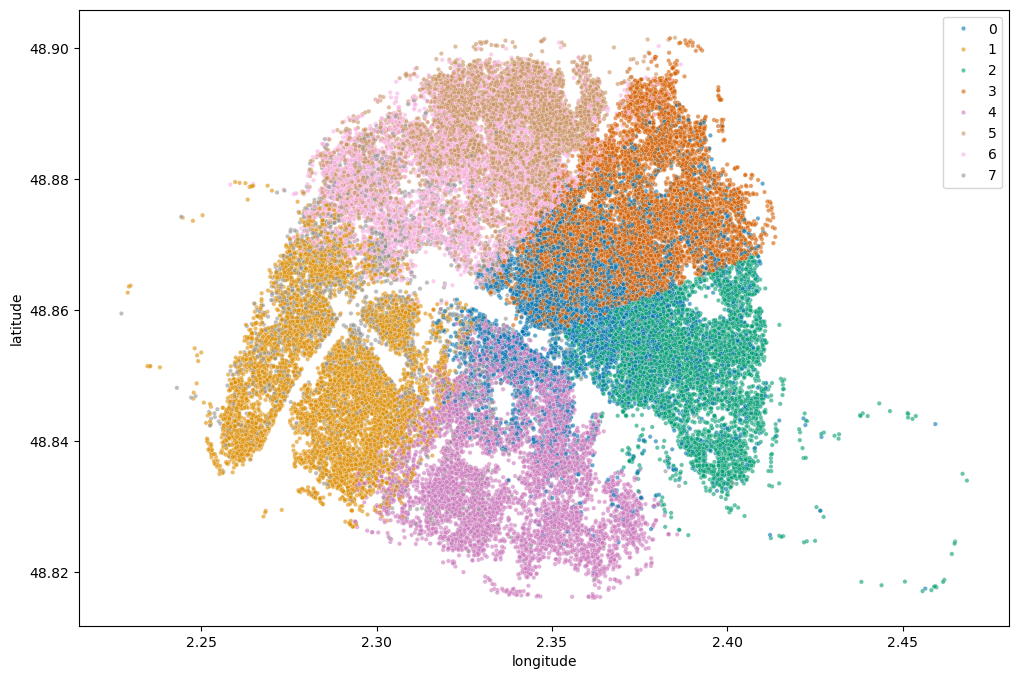

In [118]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', data=df_listings_num, hue=labels_pos, palette='colorblind', alpha=0.6, s=10)

<Axes: xlabel='price_norm', ylabel='longitude'>

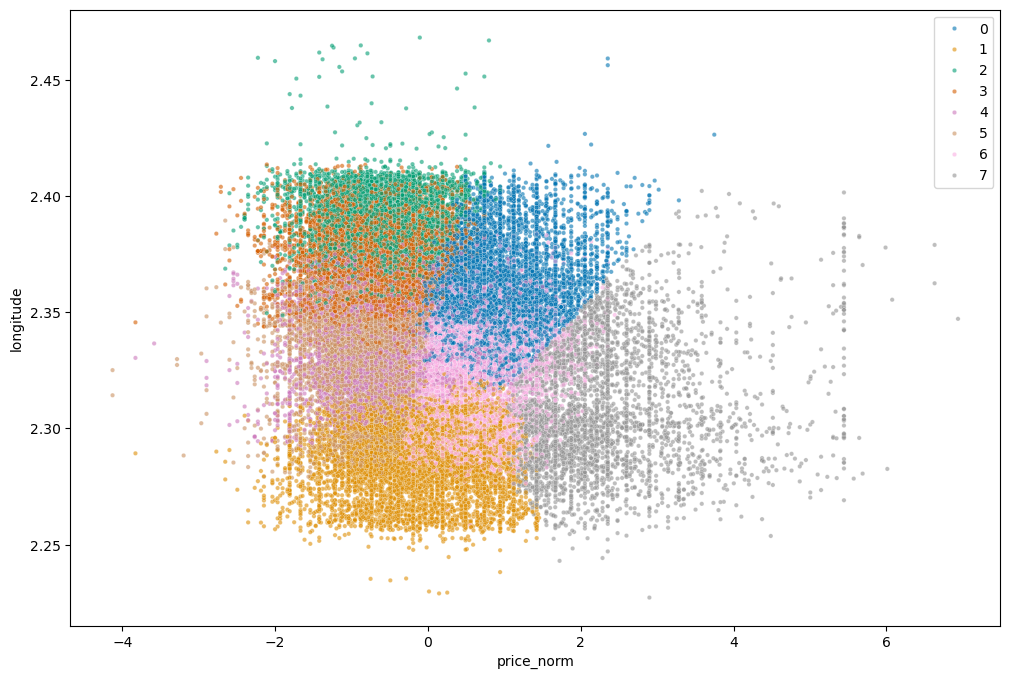

In [119]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='price_norm', y='longitude', data=df_listings_num, hue=labels_pos, palette='colorblind', alpha=0.6, s=10)

<Axes: xlabel='price_norm', ylabel='latitude'>

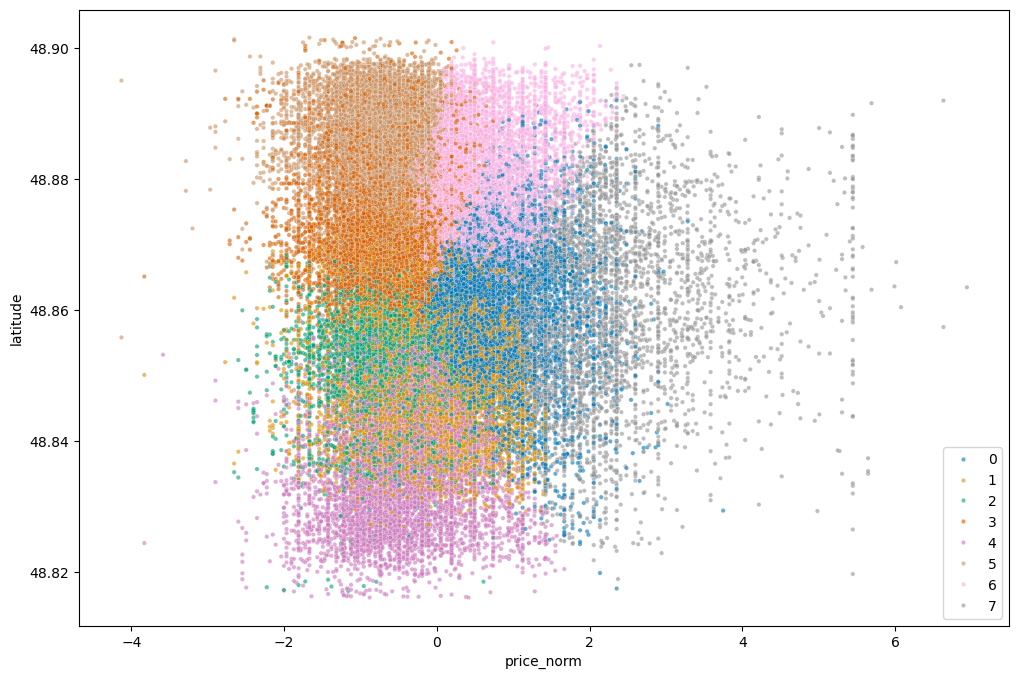

In [120]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='price_norm', y='latitude', data=df_listings_num, hue=labels_pos, palette='colorblind', alpha=0.6, s=10)

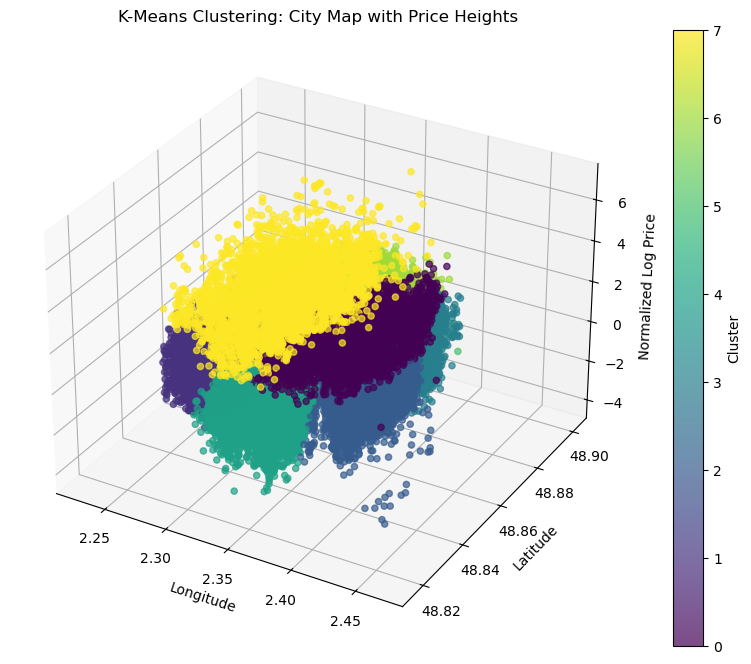

In [121]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_listings_num.longitude, df_listings_num.latitude, df_listings_num.price_norm, c=labels_pos, cmap='viridis', alpha=0.7)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Normalized Log Price')
ax.set_title('K-Means Clustering: City Map with Price Heights')

cbar=plt.colorbar(scatter)
cbar.set_label("Cluster")
plt.show()

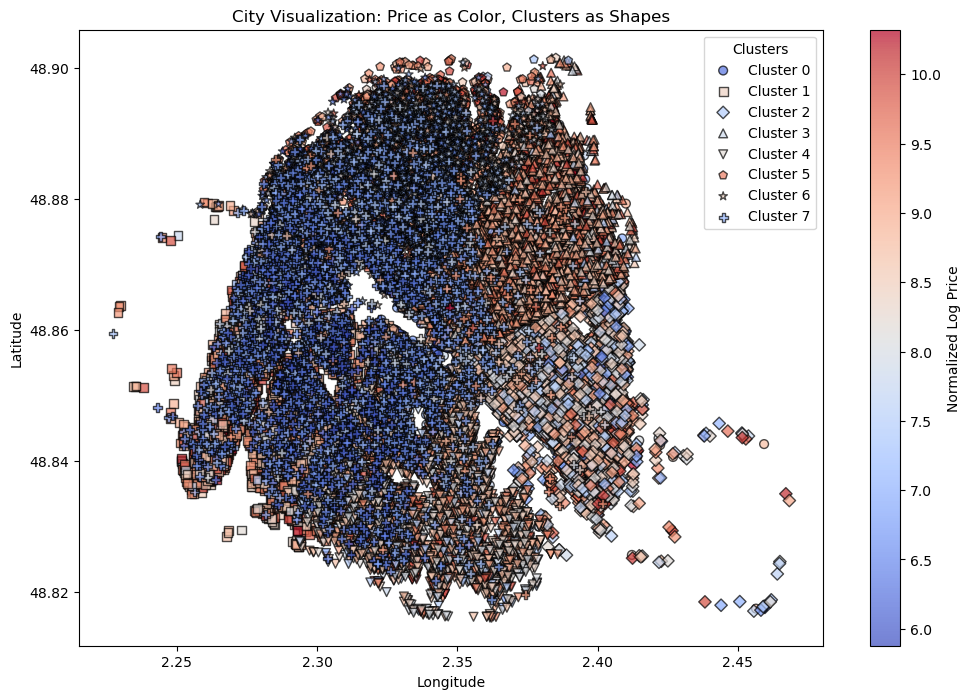

In [122]:
markers = ['o', 's', 'D', '^', 'v','p','*','P'] 

plt.figure(figsize=(12, 8))

# Loop through clusters & plot separately with different markers
for cluster in np.unique(labels_pos):
    mask = labels_lon == cluster  # Filter data for each cluster
    plt.scatter(df_listings_num.longitude[mask], df_listings_num.latitude[mask], 
                c=df_listings_num.price_log[mask], cmap='coolwarm', alpha=0.7, edgecolors='k',
                s=40, marker=markers[cluster % len(markers)], label=f'Cluster {cluster}')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Visualization: Price as Color, Clusters as Shapes')

cbar2 = plt.colorbar()
cbar2.set_label("Normalized Log Price")
plt.legend(title="Clusters")


plt.show()
